<a href="https://colab.research.google.com/github/jajapuramshivasai/projects_24/blob/main/Reference_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'tig-aluminium-5083:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F63362%2F123140%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240807%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240807T165151Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D83a01b7b722c392f61b5bb1229b957fd777b681b04d8dbcd228963fbc3a35e9b9c0ec32a9939255f69a5b70b8e97c694442e3b34268b607170fde8cedd6eef1244e08d4932c62cc1b82165ce28c61ef3609f95c935c8a9797b82376a31401b835f50a87ea6001f28c71f5c11090adfb1593648dbe9b5effde50b5fd7a11ca12ed4dfc893c6363a274ed3529aa4b28d6853b7a2381e129764fb7e04a363c7959957ff615ed6207736cbd481b364e9f5daa5733e19261bcd05c8b42f1006b39c84bbad1e1685f62d6ae013616f71689550edd2b52bf51791e5ef1e1af8555567c37a08cae0baa982b96ab9c02ebf3f5a1e3076d400efde5a143a1607a0fe082b74'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import json
import os
from PIL import Image
import random
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
train_json = '/kaggle/input/tig-aluminium-5083/al5083/train/train.json'

with open(train_json, 'r') as json_file:
    train_data_json = json.load(json_file)

In [ ]:
label_names = ["good weld", "burn through", "contamination", "lack of fusion", "misalignment", "lack of penetration"]
labels = [0, 1, 2, 3, 4, 5]
one_hot_encoding = tf.keras.utils.to_categorical(labels, num_classes=6)
label_count = [0, 0, 0, 0, 0, 0]

In [ ]:
for l in train_data_json:
    label_count[train_data_json[l]] += 1

label_count

[8758, 1783, 6325, 4028, 2953, 2819]

In [ ]:
all_data = []
image_size = (256, 256)
label_count = [0, 0, 0, 0, 0, 0]

In [ ]:
def load_data(path):
    for folder in os.listdir(path):
        folder_path = os.path.join(path, folder)
        if(os.path.isdir(folder_path)):
            for img_name in os.listdir(folder_path):

                img_path = os.path.join(folder_path, img_name)
                key_name = folder + '/' + img_name
                label = train_data_json[key_name]

                if(label_count[label] > 2000):
                    continue

                label_count[label] += 1
                image = Image.open(img_path).resize(image_size)
                image = tf.convert_to_tensor(image)
                all_data.append((image, one_hot_encoding[label]))

                if(len(all_data)%100==0):
                    print(f"Total images loaded : {len(all_data)}, Label count : {label_count}", end = '\r')

In [ ]:
load_data('/kaggle/input/tig-aluminium-5083/al5083/train')

In [ ]:
random.shuffle(all_data)

In [ ]:
X = []
y = []

for data in all_data:
    X.append(data[0])
    y.append(data[1])

In [ ]:
rand_num = np.random.randint(low = 0, high = len(all_data))
X[rand_num], y[rand_num]

(<tf.Tensor: shape=(256, 256), dtype=uint8, numpy=
 array([[13, 13, 13, ..., 15, 15, 18],
        [14, 14, 14, ..., 15, 15, 18],
        [15, 15, 15, ..., 15, 15, 17],
        ...,
        [32, 31, 32, ..., 60, 62, 61],
        [31, 30, 30, ..., 62, 61, 59],
        [31, 30, 30, ..., 63, 61, 59]], dtype=uint8)>,
 array([0., 0., 0., 0., 1., 0.], dtype=float32))

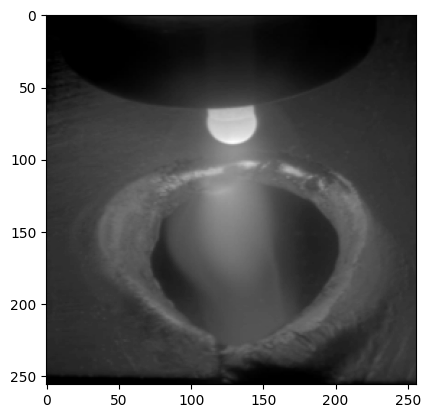

Label : burn through


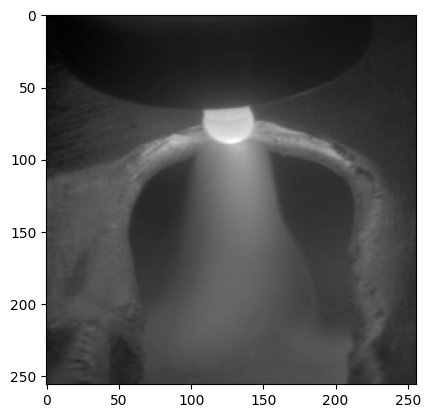

Label : burn through


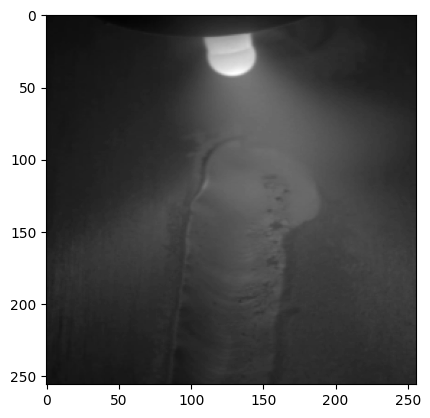

Label : misalignment


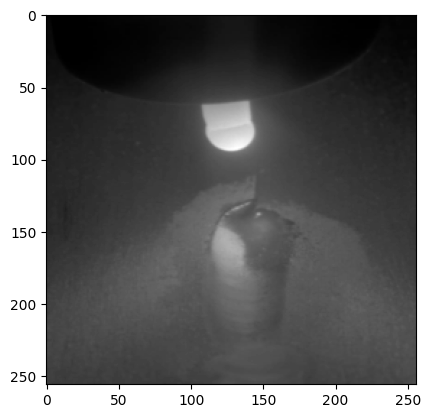

Label : contamination


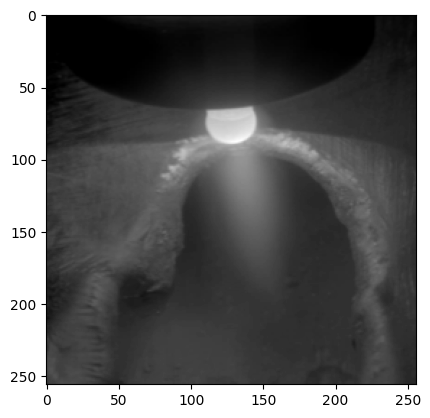

Label : burn through


In [ ]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X))
    plt.imshow(X[rand_img], cmap='gray')
    plt.show()
    print(f"Label : {label_names[np.argmax(y[rand_img])]}")

In [ ]:
total_data = len(X)
X_train, y_train = X[:int(total_data*0.8)], y[:int(total_data*0.8)]
X_test, y_test = X[int(total_data*0.8):], y[int(total_data*0.8):]

In [ ]:
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

In [ ]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

(TensorShape([9430, 256, 256]),
 TensorShape([9430, 6]),
 TensorShape([2358, 256, 256]),
 TensorShape([2358, 6]))

In [ ]:
X_train = tf.reshape(X_train, shape=(len(X_train), 256, 256, 1))
X_test = tf.reshape(X_test, shape=(len(X_test), 256, 256, 1))

X_train.shape, y_train.shape

(TensorShape([9430, 256, 256, 1]), TensorShape([9430, 6]))

In [ ]:
from tensorflow.keras import layers, regularizers

class MyModel(tf.keras.Model):

    def __init__(self, l2_reg=0.01):
        super().__init__()
        self.conv1 = layers.Conv2D(256, (3, 3), activation='relu', padding='same', input_shape=(image_size[0], image_size[1], 1), kernel_regularizer=regularizers.l2(l2_reg))
        self.pool1 = layers.MaxPooling2D((2, 2))
        self.dropout1 = layers.Dropout(0.2)

        self.conv4 = layers.Conv2D(128, (3, 3), activation='relu', padding='same', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool4 = layers.MaxPooling2D((2, 2))
        self.dropout3 = layers.Dropout(0.2)

        self.conv5 = layers.Conv2D(64, (3, 3), activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.pool5 = layers.MaxPooling2D((2, 2))

        self.flatten = layers.Flatten()

        self.dense1 = layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense2 = layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(l2_reg))
        self.dense3 = layers.Dense(len(labels), activation='softmax')

    def call(self, inputs):
        x = self.conv1(inputs)
        x = self.pool1(x)
        x = self.dropout1(x)

        x = self.conv4(x)
        x = self.pool4(x)
        x = self.dropout3(x)

        x = self.conv5(x)
        x = self.pool5(x)

        x = self.flatten(x)

        x = self.dense1(x)
        x = self.dense2(x)
        output = self.dense3(x)

        return output


In [ ]:
model = MyModel()

model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [ ]:
print(f"Train dataset Size : {len(X_train)}\nTest Dataset size : {len(X_test)}")

Train dataset Size : 9430
Test Dataset size : 2358


In [ ]:
callback1 = tf.keras.callbacks.ModelCheckpoint(
    filepath='/model',
    monitor = 'val_accuracy',
    verbose = 1,
    save_best_only = True,
    save_weights_only = True,
)

In [ ]:
model.fit(x=X_train, y=y_train, epochs=30, validation_data=(X_test, y_test), callbacks=[callback1])

Epoch 1/30


2024-08-05 21:01:24.181022: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmy_model_1/dropout_2/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


295/295 [==============================] - ETA: 0s - loss: 9.8735 - accuracy: 0.7870
Epoch 1: val_accuracy improved from -inf to 0.84690, saving model to /model
295/295 [==============================] - 117s 373ms/step - loss: 9.8735 - accuracy: 0.7870 - val_loss: 9.2411 - val_accuracy: 0.8469
Epoch 2/30
295/295 [==============================] - ETA: 0s - loss: 8.8155 - accuracy: 0.9305
Epoch 2: val_accuracy improved from 0.84690 to 0.95165, saving model to /model
295/295 [==============================] - 108s 366ms/step - loss: 8.8155 - accuracy: 0.9305 - val_loss: 8.5298 - val_accuracy: 0.9517
Epoch 3/30
295/295 [==============================] - ETA: 0s - loss: 8.3269 - accuracy: 0.9517
Epoch 3: val_accuracy did not improve from 0.95165
295/295 [==============================] - 107s 363ms/step - loss: 8.3269 - accuracy: 0.9517 - val_loss: 8.1682 - val_accuracy: 0.9394
Epoch 4/30
295/295 [==============================] - ETA: 0s - loss: 7.9110 - accuracy: 0.9687
Epoch 4: val_acc

In [ ]:
model.load_weights('/model')

In [ ]:
model.save_weights('my_model_weights.h5')

In [ ]:
from IPython.display import FileLink
FileLink('my_model_weights.h5')

/kaggle/working/my_model_weights.h5

In [ ]:
predictions = model.predict(X_test)

74/74 [==============================] - 3s 35ms/step


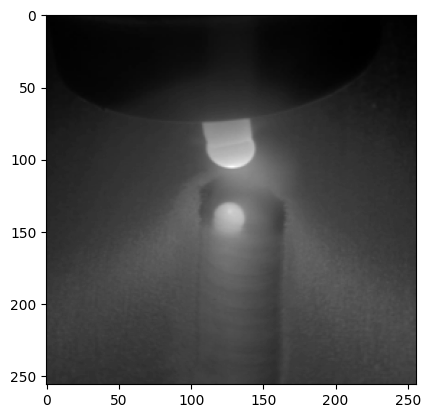

Prediction : lack of penetration
Original : lack of penetration


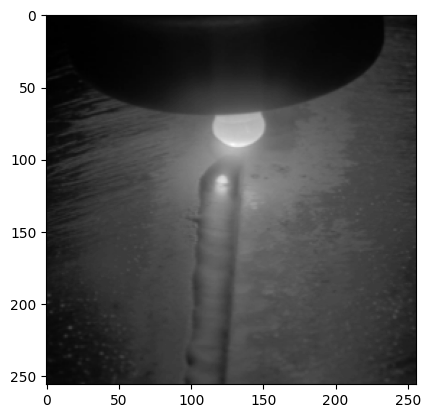

Prediction : lack of fusion
Original : lack of fusion


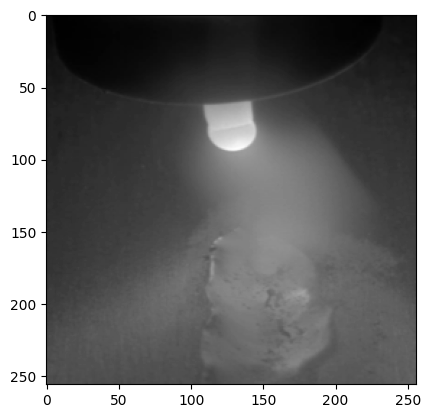

Prediction : contamination
Original : contamination


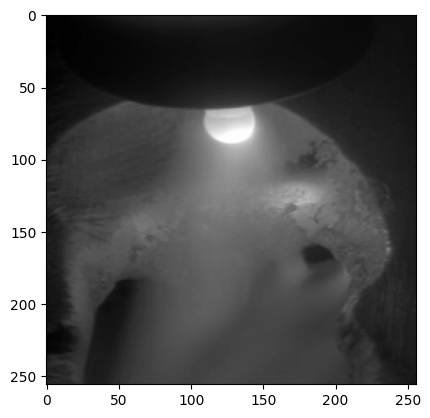

Prediction : burn through
Original : burn through


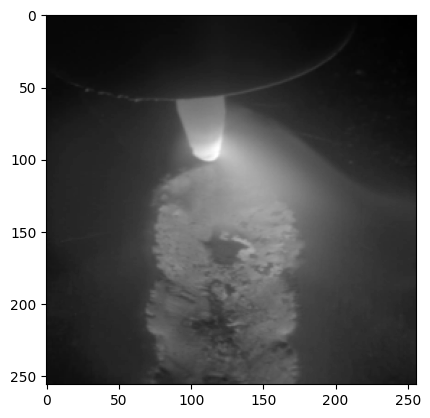

Prediction : contamination
Original : contamination


In [ ]:
for _ in range(5):
    rand_img = np.random.randint(low = 0, high = len(X_test))
    plt.imshow(X_test[rand_img].numpy(), cmap='gray')
    plt.show()
    print(f"Prediction : {label_names[np.argmax(predictions[rand_img])]}")
    print(f"Original : {label_names[np.argmax(y_test[rand_img])]}")

In [ ]:
train_metric = model.evaluate(X_train, y_train, verbose=0)
print(f"Training Loss : {train_metric[0]} , Training Accuracy : {train_metric[1]}")

Training Loss : 3.0641069412231445 , Training Accuracy : 0.9994697570800781


In [ ]:
test_metric = model.evaluate(X_test, y_test, verbose=0)
print(f"Testing Loss : {test_metric[0]} , Testing Accuracy : {test_metric[1]}")

Testing Loss : 3.0652334690093994 , Testing Accuracy : 0.9995759129524231
